In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.bert_conf
encoding_type = 'pos'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0477077043014953 	 Validation loss: 2.0104450270281 	 
  1%|          | 574/57400 [01:45<2:38:20,  5.98it/s]
Epoch 2 	 Training loss: 1.9942836852854553 	 Validation loss: 2.0018860930103366 	 
  2%|▏         | 1148/57400 [03:33<2:24:33,  6.49it/s]
Epoch 3 	 Training loss: 1.9794730616778862 	 Validation loss: 1.9814534712645968 	 
  3%|▎         | 1722/57400 [05:21<2:36:55,  5.91it/s]
Epoch 4 	 Training loss: 1.969799769880049 	 Validation loss: 1.979619030225075 	 
  4%|▍         | 2296/57400 [07:09<2:18:29,  6.63it/s]
Epoch 5 	 Training loss: 1.9673238240883326 	 Validation loss: 1.9693729958291781 	 
  5%|▌         | 2870/57400 [08:57<2:24:56,  6.27it/s]
Epoch 6 	 Training loss: 1.9612583731940398 	 Validation loss: 1.9749873411857475 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:46<2:13:59,  6.71it/s]
Epoch 7 	 Training loss: 1.9577631370946504 	 Validation loss: 1.970709568363125 	 

2 epoch without improvement
  7%|▋         | 4018/57

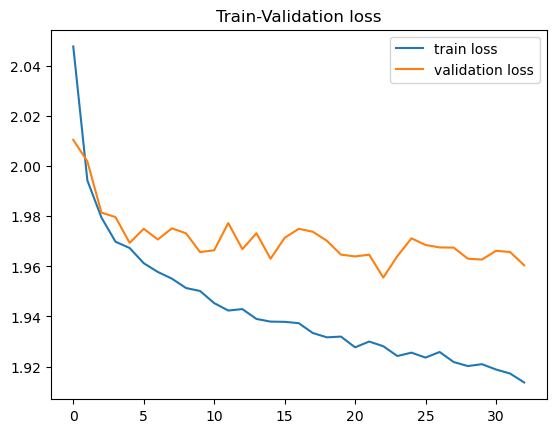

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_pos_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load('bert_multitask_pos_1'))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6856060606060606, 'precision': 0.6856060606060606, 'f1': 0.6856060606060606, 'accuracy': 0.6856060606060606}, 'as': {'recall': 0.7183833116036505, 'precision': 0.7183833116036505, 'f1': 0.7183833116036505, 'accuracy': 0.7183833116036505}, 'about': {'recall': 0.8392857142857143, 'precision': 0.8392857142857143, 'f1': 0.8392857142857143, 'accuracy': 0.8392857142857143}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7128953771289538, 'precision': 0.7128953771289538, 'f1': 0.7128953771289537, 'accuracy': 0.7128953771289538}, 'as': {'recall': 0.7272727272727273, 'precision': 0.7272727272727273, 'f1': 0.7272727272727273, 'accuracy': 0.7272727272727273}, 'about': {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6561679790026247, 'precision': 0.6561679790026247, 'f1': 0.6561679790026247, 'accuracy': 0.6561679790026247}, 'a

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0521602335707234 	 Validation loss: 2.009063171128095 	 
  1%|          | 574/57400 [01:47<2:49:44,  5.58it/s]
Epoch 2 	 Training loss: 1.990901694688232 	 Validation loss: 1.9885515055413974 	 
  2%|▏         | 1148/57400 [03:33<2:35:03,  6.05it/s]
Epoch 3 	 Training loss: 1.973936164628338 	 Validation loss: 1.9832223148669226 	 
  3%|▎         | 1722/57400 [05:19<2:52:50,  5.37it/s]
Epoch 4 	 Training loss: 1.9708344377707105 	 Validation loss: 1.9751820927959378 	 
  4%|▍         | 2296/57400 [07:05<2:24:30,  6.36it/s]
Epoch 5 	 Training loss: 1.9638680113732607 	 Validation loss: 1.9805264836650784 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:51<3:01:01,  5.02it/s]
Epoch 6 	 Training loss: 1.9620886264362403 	 Validation loss: 1.9673031528117293 	 
  6%|▌         | 3444/57400 [10:37<2:33:37,  5.85it/s]
Epoch 7 	 Training loss: 1.958698894088692 	 Validation loss: 1.9731784654875932 	 

1 epoch without improvement
  7%|▋         | 4018/

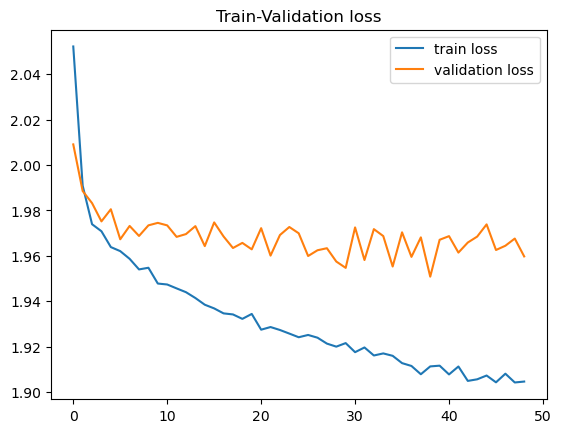

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_pos_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load('bert_multitask_pos_2'))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7058080808080808, 'precision': 0.7058080808080808, 'f1': 0.7058080808080808, 'accuracy': 0.7058080808080808}, 'as': {'recall': 0.7183833116036505, 'precision': 0.7183833116036505, 'f1': 0.7183833116036505, 'accuracy': 0.7183833116036505}, 'about': {'recall': 0.8354591836734694, 'precision': 0.8354591836734694, 'f1': 0.8354591836734694, 'accuracy': 0.8354591836734694}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7372262773722628, 'precision': 0.7372262773722628, 'f1': 0.7372262773722628, 'accuracy': 0.7372262773722628}, 'as': {'recall': 0.7348484848484849, 'precision': 0.7348484848484849, 'f1': 0.7348484848484848, 'accuracy': 0.7348484848484849}, 'about': {'recall': 0.8385416666666666, 'precision': 0.8385416666666666, 'f1': 0.8385416666666666, 'accuracy': 0.8385416666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6719160104986877, 'precision': 0.6719160104986877, 'f1': 0.6719160104986877, 'accuracy': 0.6719160104986877}, 'a

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.052297884578904 	 Validation loss: 2.004829998743736 	 
  1%|          | 574/57400 [02:02<2:46:38,  5.68it/s]
Epoch 2 	 Training loss: 1.9912396266485342 	 Validation loss: 1.9906248359356897 	 
  2%|▏         | 1148/57400 [04:10<2:46:45,  5.62it/s]
Epoch 3 	 Training loss: 1.9761550492941296 	 Validation loss: 1.9847807076017736 	 
  3%|▎         | 1722/57400 [06:18<2:50:37,  5.44it/s]
Epoch 4 	 Training loss: 1.9712637509203124 	 Validation loss: 1.9803006406557762 	 
  4%|▍         | 2296/57400 [08:27<2:45:18,  5.56it/s]
Epoch 5 	 Training loss: 1.9664527422875062 	 Validation loss: 1.9715152089878665 	 
  5%|▌         | 2870/57400 [10:34<2:40:56,  5.65it/s]
Epoch 6 	 Training loss: 1.965687858310726 	 Validation loss: 1.971118371365434 	 
  6%|▌         | 3444/57400 [12:42<2:36:48,  5.73it/s]
Epoch 7 	 Training loss: 1.9590070615246735 	 Validation loss: 1.9750194973864799 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [14:50<2:49:37,  5.24it

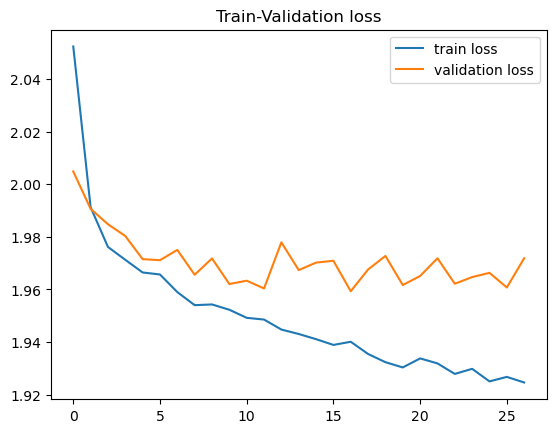

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_pos_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.702020202020202, 'precision': 0.702020202020202, 'f1': 0.702020202020202, 'accuracy': 0.702020202020202}, 'as': {'recall': 0.727509778357236, 'precision': 0.727509778357236, 'f1': 0.727509778357236, 'accuracy': 0.727509778357236}, 'about': {'recall': 0.8354591836734694, 'precision': 0.8354591836734694, 'f1': 0.8354591836734694, 'accuracy': 0.8354591836734694}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7445255474452555, 'precision': 0.7445255474452555, 'f1': 0.7445255474452555, 'accuracy': 0.7445255474452555}, 'as': {'recall': 0.7449494949494949, 'precision': 0.7449494949494949, 'f1': 0.7449494949494948, 'accuracy': 0.7449494949494949}, 'about': {'recall': 0.8567708333333334, 'precision': 0.8567708333333334, 'f1': 0.8567708333333334, 'accuracy': 0.8567708333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6561679790026247, 'precision': 0.6561679790026247, 'f1': 0.6561679790026247, 'accuracy': 0.6561679790026247}, 'as': {'re

In [16]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8367346938775511, 'precision': 0.8367346938775511, 'f1': 0.8367346938775511, 'accuracy': 0.8367346938775511}
Métricas etiqueta male: {'recall': 0.8480902777777778, 'precision': 0.8480902777777778, 'f1': 0.8480902777777778, 'accuracy': 0.8480902777777778}
Métricas etiqueta female:  {'recall': 0.8258333333333333, 'precision': 0.8258333333333333, 'f1': 0.8258333333333333, 'accuracy': 0.8258333333333333}

 to
Resultado global: {'recall': 0.6978114478114478, 'precision': 0.6978114478114478, 'f1': 0.6978114478114478, 'accuracy': 0.6978114478114478}
Métricas etiqueta male: {'recall': 0.7315490673154906, 'precision': 0.7315490673154906, 'f1': 0.7315490673154906, 'accuracy': 0.7315490673154906}
Métricas etiqueta female:  {'recall': 0.6614173228346457, 'precision': 0.6614173228346457, 'f1': 0.6614173228346457, 'accuracy': 0.6614173228346457}

 as
Resultado global: {'recall': 0.721425467188179, 'precision': 0.721425467188179, 'f1': 0.721